In [1]:
from tqdm import tqdm
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import string
from textblob import TextBlob
import preprocessor as p
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from empath import Empath


In [2]:
# df = pd.read_csv('datasets/verified_features_3k.csv')
df = pd.read_csv('datasets/unverified_features_4k.csv')

In [3]:
# dfs = pd.read_csv('users/verified_features.csv')

In [4]:
# dfs

In [5]:
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.MENTION, p.OPT.SMILEY, p.OPT.NUMBER)

In [6]:
df.head()

,uid,name,friends_count,followers_count,listed_count,statuses_count,pff,pfr,gcf,gcr,...,url,avatar,location,total_fake,total_real,net_trust,total_news,fake_prob,net_trust_norm,fake
0,14669951,DRUDGE_REPORT,2,1378378,21171,237720,1.0,3.0,2.0,2.0,...,http://t.co/dsLXEBfDsQ,https://pbs.twimg.com/profile_images/53808884/...,US,3.0,5.0,2.0,8.0,0.375000,0.250000,0.0
1,1754641,nytimesbusiness,441,786324,14641,206786,0.0,3.0,4.0,4.0,...,http://t.co/OKrfdBy4ch,https://pbs.twimg.com/profile_images/963826250...,"New York, NY",4.0,7.0,3.0,11.0,0.363636,0.272727,0.0
2,3863605355,historylvrsclub,0,544773,5041,252317,0.0,6.0,96.0,0.0,...,https://t.co/gggmdpuCSK,https://pbs.twimg.com/profile_images/111175905...,"London, England",96.0,6.0,-90.0,102.0,0.941176,-0.882353,1.0
3,53036660,GLAMOUR_sa,862,500682,355,36609,0.0,0.0,7.0,5.0,...,https://t.co/3WA7d5ciQJ,https://pbs.twimg.com/profile_images/103042295...,South Africa,7.0,5.0,-2.0,12.0,0.583333,-0.166667,1.0
4,270106571,brotips,58,464707,1504,87848,0.0,0.0,9.0,4.0,...,http://t.co/OzQz9pP0OI,https://pbs.twimg.com/profile_images/197154534...,"Los Angeles, CA",9.0,4.0,-5.0,13.0,0.692308,-0.384615,1.0


In [7]:
df = df.drop(['friends', 'created_at', 'url', 'avatar', 'location'], axis = 1)

In [8]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3366 entries, 0 to 3559
Data columns (total 19 columns):
uid                3366 non-null object
name               3366 non-null object
friends_count      3366 non-null object
followers_count    3366 non-null object
listed_count       3366 non-null object
statuses_count     3366 non-null object
pff                3366 non-null float64
pfr                3366 non-null float64
gcf                3366 non-null float64
gcr                3366 non-null float64
description        3366 non-null object
tweets             3366 non-null object
total_fake         3366 non-null float64
total_real         3366 non-null float64
net_trust          3366 non-null float64
total_news         3366 non-null float64
fake_prob          3366 non-null float64
net_trust_norm     3366 non-null float64
fake               3366 non-null float64
dtypes: float64(11), object(8)
memory usage: 525.9+ KB


In [9]:
des = list(df['description'])

In [10]:
# Happy Emoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])
 
# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

emoticons = emoticons_happy.union(emoticons_sad)

In [11]:
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

stop_words = set(stopwords.words('english'))

def clean_tweets(tweet):
    word_tokens = word_tokenize(tweet)
    
    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'‚Ä¶', '', tweet)
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)
    tweet = emoji_pattern.sub(r'', tweet)
    
    filtered_tweet = []
    
    for w in word_tokens:
        #check tokens against stop words , emoticons and punctuations
        if w not in stop_words and w not in emoticons and w not in string.punctuation:
            filtered_tweet.append(w)
    
    tweet = ' '.join(filtered_tweet).lower()
    text = ''.join([i if ord(i) < 128 else ' ' for i in tweet])
    
    return " ".join(text.split())

In [12]:
clean_desc = []

for d in des:
    d = str(d)
    d = d.replace("\'s", " ")
    d = d.replace("`", " ")
    d = d.replace("\'", " ")
    d = d.replace("#", "").replace("_", " ")
    d = p.clean(d)
    d = clean_tweets(d)
    clean_desc.append(d)

In [13]:
print('Before: ',des[0])
print()
print('After: ', clean_desc[0])

Before:  The DRUDGE REPORT is a U.S. based news aggregation website run by Matt Drudge(@DRUDGE).

After:  the drudge report u.s. based news aggregation website run matt drudge


In [14]:
df['description'] = clean_desc

In [15]:
df.head()

,uid,name,friends_count,followers_count,listed_count,statuses_count,pff,pfr,gcf,gcr,description,tweets,total_fake,total_real,net_trust,total_news,fake_prob,net_trust_norm,fake
0,14669951,DRUDGE_REPORT,2,1378378,21171,237720,1.0,3.0,2.0,2.0,the drudge report u.s. based news aggregation ...,ICE Detainer Issued for Suspected Wine Country...,3.0,5.0,2.0,8.0,0.375000,0.250000,0.0
1,1754641,nytimesbusiness,441,786324,14641,206786,0.0,3.0,4.0,4.0,financial tech media business news the new yor...,The morning after the President’s rally in Mis...,4.0,7.0,3.0,11.0,0.363636,0.272727,0.0
2,3863605355,historylvrsclub,0,544773,5041,252317,0.0,6.0,96.0,0.0,rare historical photos all copyrights belong r...,President Barack Obama and Pope Francis meet f...,96.0,6.0,-90.0,102.0,0.941176,-0.882353,1.0
3,53036660,GLAMOUR_sa,862,500682,355,36609,0.0,0.0,7.0,5.0,diverse authentic bold,Lady Gaga shows off huge engagement ring at th...,7.0,5.0,-2.0,12.0,0.583333,-0.166667,1.0
4,270106571,brotips,58,464707,1504,87848,0.0,0.0,9.0,4.0,deals for bros ... curated products make life ...,Nascar Owners Threaten To Fire Drivers Who Pro...,9.0,4.0,-5.0,13.0,0.692308,-0.384615,1.0


In [16]:
tweets = list(df['tweets'])

In [17]:
clean_tweet = []

for tweet in tweets:
    tw = tweet.split('^')
    clean_tw = []

    for d in tw:
        d = str(d)
        d = d.replace("\'s", " ")
        d = d.replace("`", "");
        d = d.replace("\"", "")
        d = d.replace("-", " ")
        d = d.replace("#", "").replace("_", " ")
        d = p.clean(d)
        d = clean_tweets(d)
        clean_tw.append(d)
#         print(clean_tw)
    clean_tweet.append("^".join(clean_tw))

In [18]:
print('Before: ',tweets[0].split("^")[2])
print()
print('After: ', clean_tweet[0].split("^")[2])

Before:  SHOCK VIDEO:  School kids taught to praise Obama... http://tinyurl.com/l3yxmg

After:  shock video school kids taught praise obama ...


In [19]:
df['tweets'] = clean_tweet

In [20]:
# df.head()

In [21]:
df.to_csv("datasets/unverified_features_clean_4k.csv", index = False)

In [22]:
# df = pd.read_csv('users/verified_features_clean.csv')

In [23]:
df.head()

,uid,name,friends_count,followers_count,listed_count,statuses_count,pff,pfr,gcf,gcr,description,tweets,total_fake,total_real,net_trust,total_news,fake_prob,net_trust_norm,fake
0,14669951,DRUDGE_REPORT,2,1378378,21171,237720,1.0,3.0,2.0,2.0,the drudge report u.s. based news aggregation ...,ice detainer issued suspected wine country ars...,3.0,5.0,2.0,8.0,0.375000,0.250000,0.0
1,1754641,nytimesbusiness,441,786324,14641,206786,0.0,3.0,4.0,4.0,financial tech media business news the new yor...,the morning president rally missouri house com...,4.0,7.0,3.0,11.0,0.363636,0.272727,0.0
2,3863605355,historylvrsclub,0,544773,5041,252317,0.0,6.0,96.0,0.0,rare historical photos all copyrights belong r...,president barack obama pope francis meet first...,96.0,6.0,-90.0,102.0,0.941176,-0.882353,1.0
3,53036660,GLAMOUR_sa,862,500682,355,36609,0.0,0.0,7.0,5.0,diverse authentic bold,lady gaga shows huge engagement ring grammys g...,7.0,5.0,-2.0,12.0,0.583333,-0.166667,1.0
4,270106571,brotips,58,464707,1504,87848,0.0,0.0,9.0,4.0,deals for bros ... curated products make life ...,nascar owners threaten to fire drivers who pro...,9.0,4.0,-5.0,13.0,0.692308,-0.384615,1.0


In [24]:
desc = list(df['description'])

In [25]:
desc_sub = []
desc_polar = []

for d in tqdm(desc):
    d = str(d)
    text = TextBlob(d)
    
    desc_sub.append(text.sentiment.subjectivity)
    desc_polar.append(text.sentiment.polarity)    

100%|██████████| 3366/3366 [00:02<00:00, 1545.99it/s]


In [26]:
df['desc_subjectivity'] = desc_sub 
df['desc_polarity'] = desc_polar

In [27]:
df.head(2)

,uid,name,friends_count,followers_count,listed_count,statuses_count,pff,pfr,gcf,gcr,...,tweets,total_fake,total_real,net_trust,total_news,fake_prob,net_trust_norm,fake,desc_subjectivity,desc_polarity
0,14669951,DRUDGE_REPORT,2,1378378,21171,237720,1.0,3.0,2.0,2.0,...,ice detainer issued suspected wine country ars...,3.0,5.0,2.0,8.0,0.375000,0.250000,0.0,0.000000,0.000000
1,1754641,nytimesbusiness,441,786324,14641,206786,0.0,3.0,4.0,4.0,...,the morning president rally missouri house com...,4.0,7.0,3.0,11.0,0.363636,0.272727,0.0,0.227273,0.068182


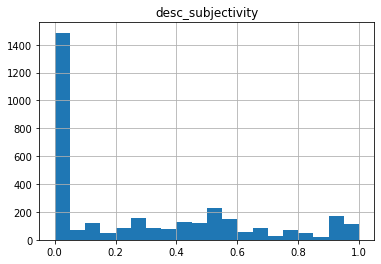

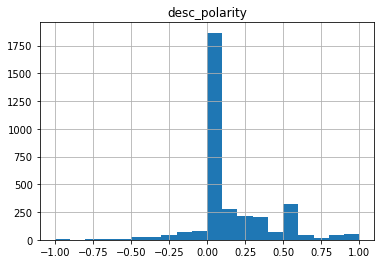

In [28]:
df.hist(column='desc_subjectivity', bins=20)
df.hist(column='desc_polarity', bins=20)

plt.show()

In [29]:
tweets = list(df['tweets'])

tweets_sub = []
tweets_polar = []

for tweet in tqdm(tweets):
    tw = tweet.split("^")
    num = len(tw)
    
    sub_arr = []
    polar_arr = []
    
    for d in tw:

        d = str(d)
        text = TextBlob(d)

        sub_arr.append(text.sentiment.subjectivity)
        polar_arr.append(text.sentiment.polarity)    

    sub = sum(sub_arr)/num
    polar = sum(polar_arr)/num    
    
    tweets_sub.append(sub)
    tweets_polar.append(polar)

100%|██████████| 3366/3366 [02:23<00:00, 23.51it/s] 


In [30]:
df['tweets_subjectivity'] = tweets_sub 
df['tweets_polarity'] = tweets_polar

In [31]:
df.head()

,uid,name,friends_count,followers_count,listed_count,statuses_count,pff,pfr,gcf,gcr,...,total_real,net_trust,total_news,fake_prob,net_trust_norm,fake,desc_subjectivity,desc_polarity,tweets_subjectivity,tweets_polarity
0,14669951,DRUDGE_REPORT,2,1378378,21171,237720,1.0,3.0,2.0,2.0,...,5.0,2.0,8.0,0.375000,0.250000,0.0,0.000000,0.000000,0.125000,-0.012500
1,1754641,nytimesbusiness,441,786324,14641,206786,0.0,3.0,4.0,4.0,...,7.0,3.0,11.0,0.363636,0.272727,0.0,0.227273,0.068182,0.145455,-0.049495
2,3863605355,historylvrsclub,0,544773,5041,252317,0.0,6.0,96.0,0.0,...,6.0,-90.0,102.0,0.941176,-0.882353,1.0,0.333333,0.100000,0.097059,0.047876
3,53036660,GLAMOUR_sa,862,500682,355,36609,0.0,0.0,7.0,5.0,...,5.0,-2.0,12.0,0.583333,-0.166667,1.0,0.708333,0.416667,0.336111,0.045833
4,270106571,brotips,58,464707,1504,87848,0.0,0.0,9.0,4.0,...,4.0,-5.0,13.0,0.692308,-0.384615,1.0,0.950000,0.750000,0.174709,0.118182


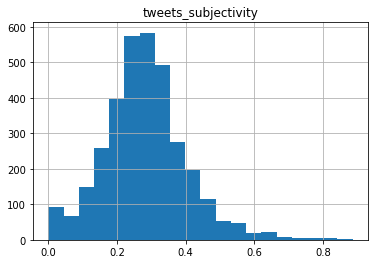

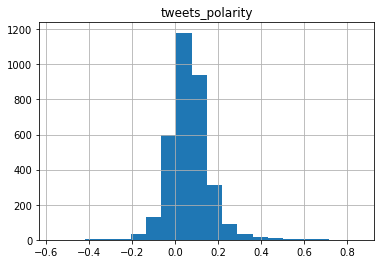

In [32]:
df.hist(column='tweets_subjectivity', bins=20)
df.hist(column='tweets_polarity', bins=20)

plt.show()

In [33]:
lexicon = Empath()

In [34]:
ex = lexicon.analyze(desc[0], normalize=True)

In [35]:
it = list(ex.items())

header = [x for (x,y) in it]

In [36]:
def column_sum(lst):   
    return [sum(i) for i in zip(*lst)] 

In [ ]:
ans = []

for tweet in tqdm(tweets):
    tw = tweet.split("^")
    num = len(tw)
    
    arr = []
    
    for d in tw:

        d = str(d)
        if d == "":
            continue
        it = list(lexicon.analyze(d, normalize=True).items())
        emp = [y for (x,y) in it]
        arr.append(emp)
    
    col_sum = column_sum(arr)
    ans.append([x/num for x in col_sum])

 54%|█████▎    | 1807/3366 [25:08<05:06,  5.09it/s]   

In [ ]:
# tweets[585].split("^")

In [ ]:
len(ans)

In [ ]:
len(ans[0])

In [ ]:
new_head = []

for head in header:
    new_head.append(head + "_empath")

In [ ]:
df_empath = pd.DataFrame(ans, columns = new_head) 

In [ ]:
df_empath

In [ ]:
cols = ['pff', 'pfr', 'gcf', 'gcr', 'description', 'tweets', 'total_fake',
        'total_real', 'net_trust', 'total_news', 'fake_prob', 'net_trust_norm']

df.drop(cols, axis=1, inplace=True)

In [ ]:
df.info()

In [ ]:
df_features = pd.concat(
    [
        df, df_empath
    ], axis=1
)

In [ ]:
df_features.head(10)

In [ ]:
# df_features = pd.read_csv('datasets/verified_features_all_300k.csv')

In [ ]:
df_features = df_features.dropna()
# df_features[df_features['uid'] == 936040869878042624]

In [ ]:
df_features.to_csv('datasets/unverified_features_all_4k.csv', index=False)

In [ ]:
df_features.hist(column='positive_emotion_empath', bins=20)


plt.show()

In [ ]:

# df_features.hist(column='friends_count', bins=20)
# df_features.hist(column='followers_count', bins=20)
# df_features.hist(column='listed_count', bins=30)
# df_features.hist(column='statuses_count', bins=30)

# plt.show()

In [ ]:
df_features.info()